# Estimation of effective connectivity using MOU process (MOU-EC)

This Python notebook estimates a matrix of whole-brain effective connectivity (MOU-EC) for each fMRI session. The dataset comprises 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie).

The goal is to fit a dynamic network model -the multivariate Ornstein-Uhlenbeck process, or MOU- to the empirical data. To do so, we tune the model parameter, in particular its connectivity MOU-EC, such that the model activity reproduces the BOLD covariances. Importantly, covariances are considered with time lags, meaning that the model aims to reproduce the statistics of the BOLD propagation between brain regions.

References:
- Appendix of Gilson et al. Biorxiv, http://doi.org/10.1101/531830
- Original version of the gradient descent: Gilson et al. PLoS Comput Biol 2016, http://doi.org/10.1371/journal.pcbi.1004762

In [1]:
# install the pyMOU library using pip
! pip install git+https://github.com/mb-BCA/pyMOU.git@master

In [2]:
import os
import numpy as np
import scipy.signal as spsg
from pymou.MOU_model import MOU
import matplotlib.pyplot as plt

res_dir = 'model_param_movie/'
if not os.path.exists(res_dir):
    print('create directory:',res_dir)
    os.makedirs(res_dir)

create directory: model_param_movie_expJ/


## Movie dataset

The data consist of 5 sessions for 22 subjects: 2 for rest (indexed by 0 and 1 in python) and 3 for movie viewing (2 to 4). Each session is 10-minute long and has 300 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to Hagmann et al. PLoS Biol 2008 with 66 regions of interest (ROIs).

The data files are:
- *ts_emp.npy*: BOLD time series (functional data)
- *SC_anat.npy*: anatomical connectome averaged over subjects (structural data)
- *ROI_labels.npy*: names of ROIs

We first filter the data in the broad frequency band [0.01,0.1] Hz, mainly to detrend the data due to very slow BOLD oscillations (with periods larger than 100 seconds).

shape of data array: (22, 5, 66, 300)


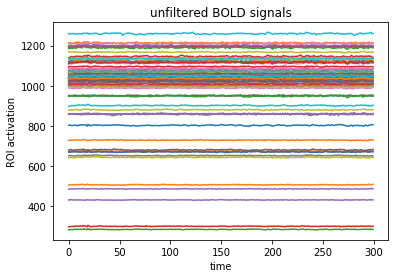

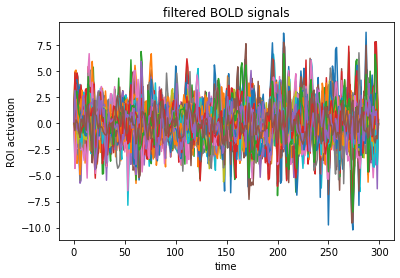

In [3]:
######################
# fMRI data properties    
n_sub = 22 # number of subjects
n_run = 5 # first 2 rest + last 3 movie
N = 66 # number of ROIs
T = 300 # number of TRs of the recording


#################
# functional data
ts_emp = np.load('ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# time resolution for fMRI signals (in seconds)
TR = 2.

# filtering between 0.01 and 0.2 Hz
n_order = 3
Nyquist_freq = 0.5 / TR
low_f = 0.01 / Nyquist_freq
high_f = 0.2 / Nyquist_freq
b,a = spsg.iirfilter(n_order, [low_f,high_f], btype='bandpass', ftype='butter')

filtered_ts_emp = spsg.filtfilt(b,a,ts_emp, axis=-1)

# plots
plt.figure()
plt.plot(range(T),ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('unfiltered BOLD signals')

plt.figure()
plt.plot(range(T),filtered_ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('filtered BOLD signals')

plt.show()

In [4]:
# labels for brain regions (ROIs)
ROI_labels = np.load('ROI_labels.npy')
print('ROI list:\n', ROI_labels)


ROI list:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' '  lTT' '  lTP' 'lSMAR'
 '  lST' '  lSP' '  lSF' ' lRMF' ' lRAC' 'lPCUN' 'lPREC' '  lPC' 'lPSTC'
 'lPCAL' 'lPTRI' 'lPORB' 'lPOPE' 'lPARH' 'lPARC' '  lMT' ' lMOF' 'lLING'
 ' lLOF' 'lLOCC' 'lISTC' '  lIT' '  lIP' ' lFUS' '  lFP' ' lENT' ' lCUN'
 ' lCMF' ' lCAC' 'lBSTS']


## Functional connectivity

Functional connectivity is typically calculated using the Pearson correlation between BOLD time series, sometimes the mutual information. 

Here we use the BOLD covariances because they are natural objective functions for the MOU model, when tuning its parameters in order to fit data (in particular the directional connectivity). 

most of the FC values should be between 0 and 1
mean FC0 value: 0.12835421704567157
max FC0 value: 17.211256019096286
mean BOLD variance (diagonal of each FC0 matrix): 0.7383493119716673


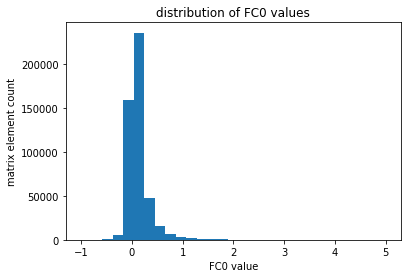

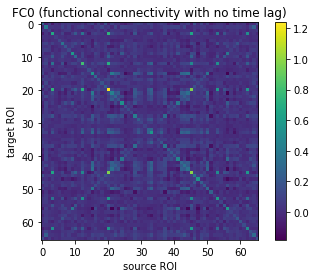

In [5]:
# time shifts for FC: 0, 1 and 2 TR
v_tau = np.arange(3,dtype=float)
n_tau = v_tau.size

FC_emp = np.zeros([n_sub,n_run,n_tau,N,N]) # FC = spatiotemporal covariances of BOLD signals
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # center the time series
        filtered_ts_emp[i_sub,i_run,:,:] -= np.outer(filtered_ts_emp[i_sub,i_run,:,:].mean(1),np.ones([T]))
        # calculate covariances with time shift
        for i_tau in range(n_tau):
            FC_emp[i_sub,i_run,i_tau,:,:] = np.tensordot(filtered_ts_emp[i_sub,i_run,:,0:T-n_tau+1],filtered_ts_emp[i_sub,i_run,:,i_tau:T-n_tau+1+i_tau],axes=(1,1)) / float((T-n_tau))

rescale_FC_factor = 0.5 / FC_emp[:,:2,0,:,:].diagonal(axis1=2,axis2=3).mean()
FC_emp *= rescale_FC_factor
filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('most of the FC values should be between 0 and 1')
print('mean FC0 value:', FC_emp[:,:,0,:,:].mean())
print('max FC0 value:', FC_emp[:,:,0,:,:].max())
print('mean BOLD variance (diagonal of each FC0 matrix):', FC_emp[:,:,0,:,:].diagonal(axis1=2,axis2=3).mean())

# show distibution of FC0 values
plt.figure()
plt.hist(FC_emp[:,:,0,:,:].flatten(), bins=np.linspace(-1,5,30))
plt.xlabel('FC0 value')
plt.ylabel('matrix element count')
plt.title('distribution of FC0 values')

# show FC0 for first subject, first run (rest)
plt.figure()
plt.imshow(FC_emp[0,0,0,:,:])
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('FC0 (functional connectivity with no time lag)')

plt.show()

0-1 time lags
mean time constant rest: 1.5460220667076947
mean time constant movie: 1.639706997801604
0-1-2 time lags
mean time constant rest: 0.6984301228992666
mean time constant movie: 0.868879782307727


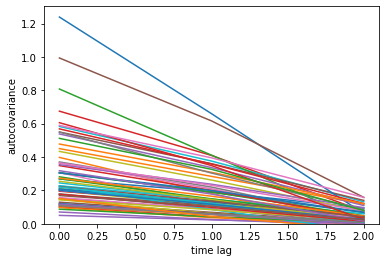

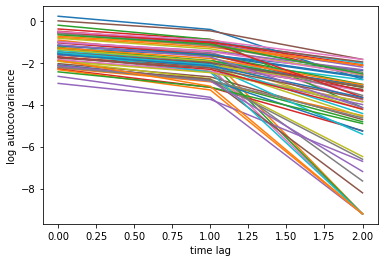

In [6]:
# autocovariance
ac = FC_emp.diagonal(axis1=3,axis2=4)

print('0-1 time lags')
print('mean time constant rest:', 1./(np.log(ac[:,:2,0,:].mean())-np.log(ac[:,:2,1,:].mean())))
print('mean time constant movie:', 1./(np.log(ac[:,2:,0,:].mean())-np.log(ac[:,2:,1,:].mean())))

print('0-1-2 time lags')
print('mean time constant rest:', 2./(np.log(ac[:,:2,0,:].mean())-np.log(ac[:,:2,2,:].mean())))
print('mean time constant movie:', 2./(np.log(ac[:,2:,0,:].mean())-np.log(ac[:,2:,2,:].mean())))

plt.figure()
plt.plot(range(3), ac[0,0,:,:])
plt.axis(ymin=0)
plt.xlabel('time lag')
plt.ylabel('autocovariance')

plt.figure()
plt.plot(range(3), np.log(np.maximum(ac[0,0,:,:],1e-4)))
plt.xlabel('time lag')
plt.ylabel('log autocovariance')

plt.show()

## Structural connectivity for movie data

The structural data (e.g. diffusion tensor imaging, or DTI) typically indicate the probability or the density of white-mater projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized. To obtain this topological information, we threshold the values of the structural matrix that gives the mask of existing connections (boolean array). Typically, we use an average over many subjects and for parcellations with 100 ROIs the density of existing connections is around 30%.

An important point to check is that the order of the ROIs is the same for the functional and structural data, which is apparent here with the "antidiagonal" of the matrices that correspond to inter-hemispheric connections between homotopic ROIs (e.g. 0 = right BSTS and 65 = left BSTS).

EC density: 0.27505827505827507


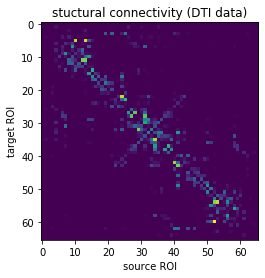

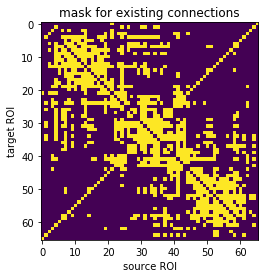

In [7]:
SC_anat = np.load('SC_anat.npy')

lim_SC = 0. # limit DTI value to determine SC (only connections with larger values are tuned)

# mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC_anat>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispheric connections
print('EC density:',mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N,dtype=bool)

# plots
plt.figure()
plt.imshow(SC_anat)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('stuctural connectivity (DTI data)')

plt.figure()
plt.imshow(mask_EC)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('mask for existing connections')

plt.show()

## MOU-EC estimation

The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the *MOU_Simulation_Estimation* notebook.

A few technical points:
- The current version of the gradient descent has slightly evolved since the original paper (Gilson et al. PLoS Comput Biol 2016, http://doi.org/10.1371/journal.pcbi.1004762), to refine the optimization of both connectivity matrix $C$ and input covariance matrix $\Sigma$. The current version is explained in the Appendix of Gilson et al. Biorxiv, http://doi.org/10.1101/531830.
- The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates. Try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with *mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)*.
- In addition to the topological constraint (*mask_C*), it is possible to set a similar constraint on the input covariance (using *mask_Sigma*). Usually, we use a diagonal $\Sigma$, but see Gilson et al. Neuroimage 2018, http://doi.org/10.1016/j.neuroimage.2017.09.061 for considerations about inputs with cross-correlations.

In [8]:
####################
# model optimization
J_mod = np.zeros([n_sub,n_run,N,N]) # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,n_run,N,N]) # local variance (input covariance matrix, chosen to be diagonal)
dist_mod = np.zeros([n_sub,n_run]) # model error
R2_mod = np.zeros([n_sub,n_run]) # explained variance about the fitted data (FC covariance matrices)

mou_model = MOU()

for i_sub in range(n_sub):
    for i_run in range(n_run):
        # estimate model parameters for each session
        mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T,mask_C=mask_EC,mask_Sigma=mask_Sigma) # , regul_C=0.5

        J_mod[i_sub,i_run,:,:] = mou_model.J # Jacobian of the model
        Sigma_mod[i_sub,i_run,:,:] = mou_model.Sigma
        dist_mod[i_sub,i_run] = mou_model.d_fit['distance'] # matrix distance between the empirical objective covariances and their model counterparts (normalized for each objective matrix)
        R2_mod[i_sub,i_run] = mou_model.d_fit['correlation']**2 # the squared Pearson correlation is taken as an approximation of the variance explained R2 here

        print('sub / run:',i_sub,i_run,'; model error, R2',dist_mod[i_sub,i_run], R2_mod[i_sub,i_run])

# save results
np.save(res_dir+'FC_emp.npy',FC_emp) # empirical spatiotemporal FC
np.save(res_dir+'mask_EC.npy',mask_EC) # mask of optimized connections
np.save(res_dir+'mask_Sigma.npy',mask_Sigma) # mask of optimized Sigma elements

np.save(res_dir+'J_mod.npy',J_mod) # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod) # estimated Sigma matrices
np.save(res_dir+'dist_mod.npy',dist_mod) # model error

sub / run: 0 0 ; model error, R2 0.81631922603513 0.2473328208716842
sub / run: 0 1 ; model error, R2 0.7718388025814482 0.24897741384011784
sub / run: 0 2 ; model error, R2 0.7571189729796832 0.23850826098557046
sub / run: 0 3 ; model error, R2 0.7613468229653673 0.3173013452632276
sub / run: 0 4 ; model error, R2 0.7722433319542577 0.26340245630078224
sub / run: 1 0 ; model error, R2 0.7425414202010924 0.1997957406432711
sub / run: 1 1 ; model error, R2 0.7202077460826105 0.3223077684004832
sub / run: 1 2 ; model error, R2 0.8044765789562756 0.24001763763606584
sub / run: 1 3 ; model error, R2 0.7612731175516514 0.26368457350624536
sub / run: 1 4 ; model error, R2 0.7996324547296227 0.24845849972588063
sub / run: 2 0 ; model error, R2 0.6684732905764139 0.3749130975439808
sub / run: 2 1 ; model error, R2 0.6988854609080529 0.30015768280408944
sub / run: 2 2 ; model error, R2 0.7738112181147359 0.3373613338408375
sub / run: 2 3 ; model error, R2 0.8180556723240212 0.2503816812681502
s

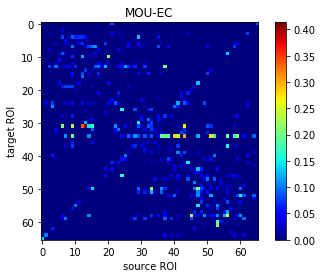

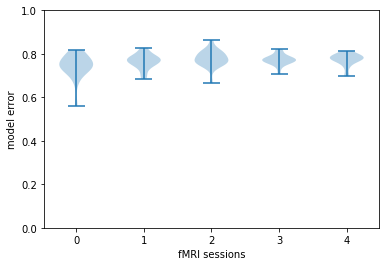

In [9]:
# display an exmaple MOU-EC matrix and the model error for all runs and subjects
i_sub = 0
i_run = 0

plt.figure()
plt.imshow(J_mod[i_sub,i_run,:,:], vmin=0, cmap='jet')
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.colorbar()
plt.title('MOU-EC')

plt.figure()
plt.violinplot(dist_mod,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions')
plt.ylabel('model error')

plt.show()

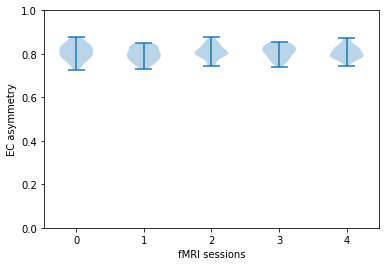

In [10]:
def asym(X):
    return np.abs(X-X.T).sum() / np.abs(X).sum() / 2

asym_EC = np.zeros([n_sub,n_run])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        C_tmp = J_mod[i_sub,i_run,:,:]
        C_tmp[np.eye(N,dtype=np.bool)] = 0
        asym_EC[i_sub,i_run] = asym(C_tmp)
        
plt.figure()
plt.violinplot(asym_EC,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions')
plt.ylabel('EC asymmetry')

plt.show()

## Further exercises

- Compare EC between rest and movie using statistical testing (e.g. Welch t-test).
- Compare graph metrics on EC (as a directed weighted matrix) to corresponding graph metrics on SC, for example the node strength/degree to see how their hierarchy may differ (in particular between the two conditions, rest and movie).
- Compare EC with partial correlations PC.